<h1>概率图模型采样方法</h1>

> <b>解决问题</b>

> 从数据分布中采样，尤其是高维数据分布

参考文献：

[1] Pattern recognition and machine learning, Chapter 11.

[2] Machine Learning, A Probabilistic Perspective, Chapter 23, 24.

[3] LDA数学八卦.

# 0. 采样 (Sampling)

假设有一个分布，一共三个离散值[A, B, C]，其概率分布为[0.3, 0.5, 0.2]。如果需要从该分布中采样一系列样本，一个直观的做法是从$u\sim U(0, 1)$中采样。

+ $x = A, if 0 <= u <= 0.3$, 
+ $x = B, if 0.3 < u <= 0.8, (0.8=0.3 + 0.5)$, 
+ $x = C, if 0.8 < u <= 1,(1=0.3 + 0.5 + 0.2)$.

因此，可以通过计算待采样分布的累计概率函数，通过均匀分布来抽样标准分布。


# 1. 标准分布直接采样 （Sampling from Standard Distribution）

>定理: $F$是我们要采样的函数$p(x)$的累积密度函数(cdf)，如果$u\sim U(0, 1)$， 则$F^{-1}(u)\sim F$.
>证明见MLAPP.

采样过程：

（1）采样$u\sim U(0, 1)$；

（2）计算$x=F^{-1}(u)$。

直接采样需要计算累积密度函数的逆函数，如果累计密度函数或者逆函数难以计算，则该方法不适用。




# 2. 拒绝采样 （Rejection Sampling）

如果待采样分布$p(x)$难以直接采样，建立一个参考分布$q(x)$，使得对于某些固定的参数$M$，满足$Mq(x)\geq \tilde{p}(x)$。其中$\tilde{p}(x)$是$p(x)$的一个未归一化的版本，例如，$p(x)=\tilde{p}(x)/Z_{p}$，$Z_{p}$是一个固定的归一化参数。则函数$Mq(x)$是$\tilde{p}(x)$的一个上界包围。

采样过程：

（1）采样$x\sim q(x)$；

（2）采样$u\sim U(0,1)$；

（3）接受率$r=\frac{\tilde{p}(x)}{Mq(x)}$，如果$u<r$，接受本次采样，否则拒绝；

拒绝采样的$M$不好设置，设置的过小，$q(x)$无法全部包围住$p(x)$；设置的过大，则接受率太低，采样效率太低。也要求$q(x)$既便于采样，又要从形状上比较接近$p(x)$，在高维情况或者$p(x)$很复杂的情况下难以满足。

> 问题：(1)$q(x)$如何选取？(2)$M$如何确定？


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math

In [29]:
# p(x) ~ norm(0, 1)
# q(x) = U(1, 2), M = 0.4
x = np.arange(-4, 4, 0.2)
y = list(map(lambda i : 1. / math.sqrt(2 * math.pi) * math.exp(-i ** 2 / 2), x))

In [46]:
z = []
M = 0.4
for i in np.arange(-4, 4, 0.0001):
    while True:
        # q(x)
        q = np.random.uniform(-4, 4) 
        p = 1. / math.sqrt(2 * math.pi) * math.exp(- i ** 2 / 2)    
        r = p / (M*abs(q))
        u = np.random.uniform(0, 1)
    
        if u <= r:
            z.append(q)
            break

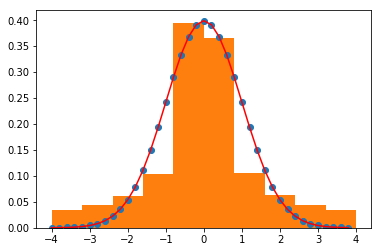

In [47]:
plt.plot(x, y, 'o')
plt.plot(x, y, 'r')
plt.hist(z, normed=1)
plt.show()

# 3. 重要性采样 （Importance Sampling）

如果计算积分（或者面积，比如通过计算面积来估计$\pi$），

（1）采样该积分定义区间上的均匀分布$u\sim U(a,b)$；

（2）计算采样处的积分值，对所有值取均值（根据大数定律），用均值来估算期望（再根据区间长度计算积分值）。

这样的计算方法假设所有采样得到的值权重相同（对最后的积分值贡献相同），实际上，当数据分布不是均匀分布的时候，这个假设不成立。

重要性采样对每处采样赋予不同的权重。

> $E[f] = \int f(x) \frac{p(x)}{q(x)} q(x) dx \approx \frac{1}{S} \sum_{s=1}^{S} w_s f(x^s) = \hat I$。

与拒绝采样不同，重要性采样每次采样的样本都会使用，但是赋予不同的权重。

> 问题：$q(x)$如何选取？

# 4. 马尔科夫链蒙特卡罗(MCMC)

拒绝抽样与重要性抽样在数据维度很高时难以发挥作用（如$q(x)$难以选取）。

## MCMC采样基本原理

> 构造马尔科夫链及转移矩阵，使得马尔科夫链达到平稳状态时收敛到待抽样的目标分布$p(x)$。

## 细致平稳条件
> 如果非周期马氏链的转移矩阵$T(i, j)$以及分布$p(x)$满足

> $p(i)T(i,j) = p(j)T(j,i)$, for all $i, j$. 

> 则$p(x)$是马氏链上的平稳分布，上式被称为细致平稳条件。

如果细致平稳条件成立，则可抽样达到平稳分布之后的马氏链，即为待采样分布$p(x)$。


## Metropolis-Hastings 方法

如果细致平稳条件不成立，引入一个对称参考分布$A(i,j)=A(j,i)$，使得

> $p(i)T(i,j)A(i,j) = p(j)T(j,i)A(j,i)$

+ 按照对称性，取$A(i,j)=p(j)T(j,i)$，$A(j,i)=p(i)T(i,j)$，则将普通的转移矩阵为$T$的马氏链变成转移矩阵为$A$的马氏链。转变后的马氏链满足细致平稳条件，马氏链的平稳分布是$p(x)$。

+ $A(i,j)$可以看做是接受率，如果接受率太小，会影响抽样效率。可以将等式两边同比例放大，将$A(i,j)$与$A(j,i)$两个中较大的一个放大到1，从而提高采样中的跳转接受率。$A(i,j)=min\{\frac{p(j)T(j,i)}{p(i)T(i,j)}, 1\}$。

<b>采样过程</b>

(1)随机初始化马氏链$X_0=x_0$；

(2)对$t$=0,1,...，循环以下采样过程:
> + 第$t$个时刻马氏链状态为$X_t=x_t$，采样$y=T(x_t, x)$;
> + 从均匀分布$u\sim U(0,1)$中采样;
> + 计算接受率$A(x_t,x)=min\{\frac{p(x)T(x,x_t)}{p(x_t)T(x_t,x)}, 1\}$;
> + 如果$u<r$，接受转移，$X_{t+1}=y$；否则拒绝转移，$X_{t+1}=x_t$。

## Gibbs Sampling 方法

在高维的情况下，由于接受率$A(i,j)$通常小于1，会存在拒绝转移的情况，从而Metropolis-Hastings方法不够高效。如果存在一个转移矩阵$Q$，使得接受率$A(i,j)=1$，则抽样效率会大大提高。

对于$K$维分布$p(\vec{x})$，如果在抽样过程中只有第$k$维变量$x_k$参与计算，除去第$k$维的其它维度$\vec{x_{-k}}$保持不变。如果令

> $T_{k}(\vec{x^i}, \vec{x^j}) = p(x_k^j|\vec{x_{-k}^i}) $

则接受率



> $A_k(\vec{x^i}, \vec{x^j}) = \frac{ p(\vec{x^j})  T_k(\vec{x^j}, \vec{x^i})}{p(\vec{x^i})  T_k(\vec{x^i}, \vec{x^j})} = \frac{p(x_k^j|\vec{x_{-k}^j})p(\vec{x_{-k}^j})p(x_k^i|\vec{x_{-k}^j})}{p(x_k^i|\vec{x_{-k}^i})p(\vec{x_{-k}^i})p(x_k^j|\vec{x_{-k}^i})} = \frac{p(\vec{x_{-k}^j})}{p(\vec{x_{-k}^i})}=1 $, 因为$p(\vec{x_{-k}^i})=p(\vec{x_{-k}^j})$。

<b>采样过程</b>

(1)随机初始化向量$\{\vec{x_k^0}:k=1,2,...K\}$

(2)对$t=0,1,2,...$循环采样:
> + $\vec{x_1^{t+1}}\sim p(x_1|x_2^t, x_3^t, ..., x_K^t)$ 

> + $\vec{x_2^{t+1}}\sim p(x_2|x_1^{t+1}, x_3^t, ..., x_K^t)$ 

> + ...

> + $\vec{x_K^{t+1}}\sim p(x_K|x_1^{t+1}, x_2^{t+1}, ..., x_{K-1}^{t+1})$ 

坐标轴的采样不一定要按照从1到$K$的顺序。